# colab imports

In [1]:
!pip install PyDrive

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
downloaded = drive.CreateFile({'id':"1e4gYrXHYp6o2awdu9DKPckL--E6i6FIN"})   # replace the id with id of file you want to access
downloaded.GetContentFile('quiescent_cosmos2015.csv')        # replace the file name with your file

downloaded = drive.CreateFile({'id':"1hepS7L_Jgpt5ZrLhj60O1EBzchlQHPp9"})   # replace the id with id of file you want to access
downloaded.GetContentFile('sf_cosmos2015.csv')        # replace the file name with your file

# Analysis of the COSMOS2015 survey for z<4

In [7]:
 # Code to perform fractal analysis in large astronomical surveys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from scipy import constants
from scipy import stats
from scipy.stats import linregress
from scipy import odr
import matplotlib.ticker as ticker
from astropy.cosmology import LambdaCDM, z_at_value
paramet = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)

# Importing tables
tabela_qst = pd.read_csv("quiescent_cosmos2015.csv")
tabela_sf = pd.read_csv("sf_cosmos2015.csv")

# Selecting sample
tabela=[]
sel_uvista = (tabela_sf['FLAG_HJMCC']==0)&(tabela_sf['TYPE']==0)&(tabela_sf['ZPDF']>0.0)
tabela = tabela_sf[sel_uvista]
dl = paramet.luminosity_distance(tabela.ZPDF).values.value
selacima  = (tabela['MK'] <= (-5*np.log10(dl) - 0.3)) & (tabela['ZPDF'] < 4.0) & (tabela['MK'] > -90)
MK_ABOVE = tabela[selacima]

dl = paramet.luminosity_distance(MK_ABOVE.ZPDF).values.value

# Unity of H0 is km/Mpc.s
H0 = paramet.H(0)
c = 299792 #km/s
z = MK_ABOVE.ZPDF
dz = (c*z) / H0
dg = dl/(1+z)

# Inferior uncertainty
dl_inf = paramet.luminosity_distance(MK_ABOVE.ZPDF_L68).values.value
H0 = paramet.H(0)
c = 299792 #km/s
z_inf = MK_ABOVE.ZPDF_L68
dz_inf = (c*z_inf) / H0
dg_inf = dl_inf/(1+z_inf)

# Upper uncertainty
dl_sup= paramet.luminosity_distance(MK_ABOVE.ZPDF_H68).values.value
H0 = paramet.H(0)
c = 299792 #km/s
z_sup = MK_ABOVE.ZPDF_H68
dz_sup = (c*z_sup) / H0
dg_sup = dl_sup/(1+z_sup)

 # Functions to assist in our analysis
 # 1) Find redshift from dl, in order to find dg(z) relation
def find_z(dist):
    z_test=np.arange(0.001,7.05,0.0001)
    dg_test = paramet.luminosity_distance(z_test).value/(1+z_test)
    i=0
    test= dg_test[i]
    while round(test,2)<round(dist,2):
        i=i+1
        test=dg_test[i]
        z_out=z_test[i]
        dist_out = test
    return z_out

# 2) Function to generate gama density in respect to a given distance
def gama_dist(dbin, dist, dist_sup, dist_inf, dist_type):
  list_count = []
  list_count_sup = []
  list_count_inf = []
  list_gama = []
  list_gama_sup = []
  list_gama_inf = []
  list_dist = []
  list_z = []
  count = 0
  dmin = min(dist)

  while count < len(dist):
    d = dmin + dbin
    # Center values:
    sel = dist<(d)
    dist_sel=dist[sel]
    count = len(dist_sel)
    list_count.append(count)

    # Upper values:
    sel_sup = dist_sup<(d)
    dist_sel_sup=dist_sup[sel_sup]
    count_sup = len(dist_sel_sup)
    list_count_sup.append(count_sup)

    # Inferior values:
    sel_inf = dist_inf<(d)
    dist_sel_inf=dist_inf[sel_inf]
    count_inf= len(dist_sel_inf)
    list_count_inf.append(count_inf)

    if dist_type=='dL':
      z_lim_dist = z_at_value(paramet.luminosity_distance, d*u.Mpc)
    if dist_type=='dZ':
      z_lim_dist = (d*H0.value)/c
    if dist_type=='dG':
      z_lim_dist = find_z(d)

    volume = (4/3)*np.pi*((d)**3)
    gama = count/volume
    gama_sup = count_sup/volume
    gama_inf = count_inf/volume

    list_gama.append(gama)
    list_gama_sup.append(gama_sup)
    list_gama_inf.append(gama_inf)
    list_dist.append(d)
    list_z.append(z_lim_dist)
    dmin = d

  return np.array(list_gama), np.array(list_gama_sup), np.array(list_gama_inf), np.array(list_dist), np.array(list_z)

# 3) Linear regression with error in both axis
def func(p,x):
    a,b=p
    return a*x+b

# 4) Axis label format
def label_form(x, pos):
    if x<1:
        xla=float(x)
        x=xla
    if x>=1:
        xla=int(x)
        x=xla
    return str(x)

# 5) Function to find slopes of gama vs dist (linear regression)
def slopes(dist_type,dist,gama,gama_lim_sup):

  # Cut related to z=1
  listateste=[]
  if dist_type == 'dL':
    for i in listaz1:
        if i>1:
            listateste.append(i)
    cut_dist = len(listaz1) - len(listateste)
  if dist_type == 'dZ':
    for i in listazz1:
      if i>1:
          listateste.append(i)
    cut_dist = len(listazz1) - len(listateste)
  if dist_type == 'dG':
    for i in listazg2:
        if i>1:
            listateste.append(i)
    cut_dist = len(listazg2) - len(listateste)

  # Linear regression for z > 1
  data_x = np.log10(dist[cut_dist:-1:])
  data_y = np.log10(gama[cut_dist:-1:])
  data_y_err = np.log10(gama_lim_sup[cut_dist:-1:]) - np.log10(gama[cut_dist:-1:])
  # Linear regression with error in both axis:
  def func(p,x):
      a,b=p
      return a*x+b
  from scipy import odr
  linear_model = odr.Model(func)
  data = odr.RealData(data_x,data_y,sy=data_y_err)
  odr = odr.ODR(data,linear_model,beta0=[1.,1.])
  out = odr.run()
  slope_g = out.beta[0]
  err_slope_g = out.sd_beta[0]
  interp_g = out.beta[1]
  err_interp_g = out.sd_beta[1]
  # Linear regression for z < 1
  from scipy import odr
  data_x = np.log10(dist[:cut_dist:])
  data_y = np.log10(gama[:cut_dist:])
  data_y_err = np.log10(gama[:cut_dist:]) - np.log10(gama_lim_sup[:cut_dist:])
  # Linear regression with error in both axis:
  def func(p,x):
      a,b=p
      return a*x+b
  linear_model = odr.Model(func)
  data = odr.RealData(data_x,data_y,sy=data_y_err)
  odr = odr.ODR(data,linear_model,beta0=[1.,1.])
  out = odr.run()
  slope_l = out.beta[0]
  err_slope_l = out.sd_beta[0]
  interp_l = out.beta[1]
  err_interp_l = out.sd_beta[1]
  return slope_g, err_slope_g, interp_g,err_interp_g, slope_l, err_slope_l, interp_l,err_interp_l


# 6) Function to create gama plots
def gama_plot(dist,gama,z,type_dist,gama_lim_sup,gama_lim_inf,slope_l,err_slope_l,interp_l,slope_g,err_slope_g,interp_g):
  plt.figure(figsize=(15,15))
  # Graph of gama_di vs d_i where i=l,z,g with bin of 200mpc and z plotted above
  fig = plt.figure()
  # Create first subplot:
  ax1 = fig.add_subplot(111)

  if type_dist=='L':
    # For the first plot:
    ax1.plot(np.log10(dist),np.log10(gama),'kx',label='$\gamma^{*}$')
    ax1.plot(np.log10(dist),interp_g_dl + slope_g_dl*np.log10(dist),'k--',label='slope(z>1) ='+str("%.2f" % round(slope_g_dl,2))+'$\pm$'+str(round(err_slope_g_dl,2)))
    ax1.plot(np.log10(dist),interp_l_dl + slope_l_dl*np.log10(dist),'k:',label='slope(z<1) ='+str("%.2f" % round(slope_l_dl,2))+'$\pm$'+str(round(err_slope_l_dl,2)))
    # Hatched area with error only on y axis
    ax1.fill_between(np.log10(dist),np.log10(gama_lim_inf),np.log10(gama_lim_sup),facecolor='grey')
    ax1.set_xlabel('$\log[d_{L}$(Mpc)]', fontsize=18)
    ax1.set_ylabel('$\log[\gamma_{L}^{*}$(Mpc$^{-3}$)]', fontsize=18)

  if type_dist=='Z':
    ax1.plot(np.log10(dist),np.log10(gama),'kx',label='$\gamma^{*}$')
    ax1.plot(np.log10(dist),interp_g_dz + slope_g_dz*np.log10(dist),'k--',label='slope(z>1) ='+str("%.2f" % round(slope_g_dz,2))+'$\pm$'+str(round(err_slope_g_dz,2)))
    ax1.plot(np.log10(dist),interp_l_dz + slope_l_dz*np.log10(dist),'k:',label='slope(z<1) ='+str("%.2f" % round(slope_l_dz,2))+'$\pm$'+str(round(err_slope_l_dz,2)))
    ax1.fill_between(np.log10(dist),np.log10(gama_lim_inf),np.log10(gama_lim_sup),facecolor='grey')
    ax1.set_xlabel('$\log[d_{Z}$(Mpc)]', fontsize=18)
    ax1.set_ylabel('$\log[\gamma_{Z}^{*}$(Mpc$^{-3}$)]', fontsize=18)

  if type_dist=='G':
    ax1.plot(np.log10(dist),np.log10(gama),'kx',label='$\gamma^{*}$')
    ax1.plot(np.log10(dist),interp_g_dg + slope_g_dg*np.log10(dist),'k--',label='slope(z>1) ='+str("%.2f" % round(slope_g_dg,2))+'$\pm$'+str(round(err_slope_g_dg,2)))
    ax1.plot(np.log10(dist),interp_l_dg + slope_l_dg*np.log10(dist),'k:',label='slope(z<1) ='+str("%.2f" % round(slope_l_dg,2))+'$\pm$'+str(round(err_slope_l_dg,2)))
    ax1.fill_between(np.log10(dist),np.log10(gama_lim_inf),np.log10(gama_lim_sup),facecolor='grey')
    ax1.set_xlabel('$\log[d_{G}$(Mpc)]', fontsize=18)
    ax1.set_ylabel('$\log[\gamma_{G}^{*}$(Mpc$^{-3}$)]', fontsize=18)

  ax1.legend(loc=3, prop={'size': 11.5})
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  # Create second subplot keeping the y axis of first plot
  ax2 = ax1.twiny()
  # For the second plot
  ax2.plot(z,np.log10(gama),alpha=0)
  ax2.semilogx()
  ax2.set_xticks([0.2,0.5,1,2,3,4])
  ax2.xaxis.set_major_formatter(ticker.FuncFormatter(label_form)) # Formatting number values of second axis
  ax2.set_xlabel('z',fontsize=18)
  plt.xticks(fontsize=13)
  # Vertical line
  plt.axvline(x=1, color='k', linestyle='-')
  plt.show()
  return

<Figure size 1500x1500 with 0 Axes>

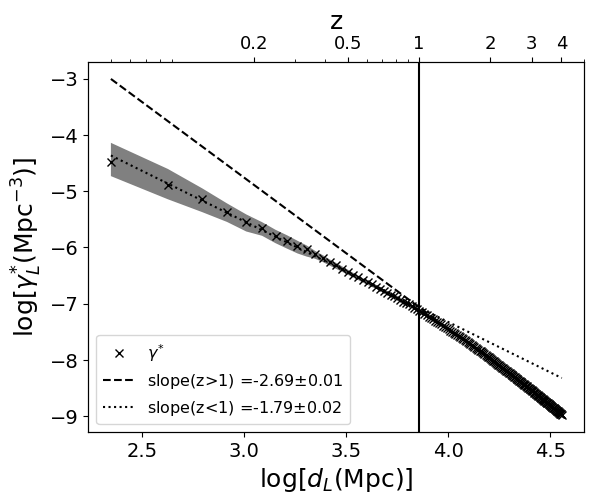

<Figure size 1500x1500 with 0 Axes>

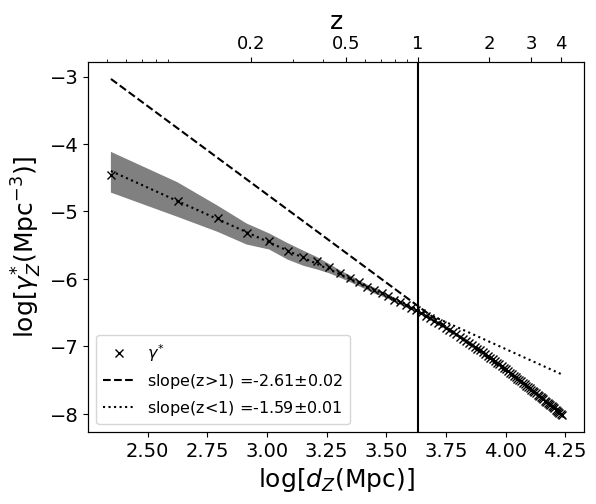

<Figure size 1500x1500 with 0 Axes>

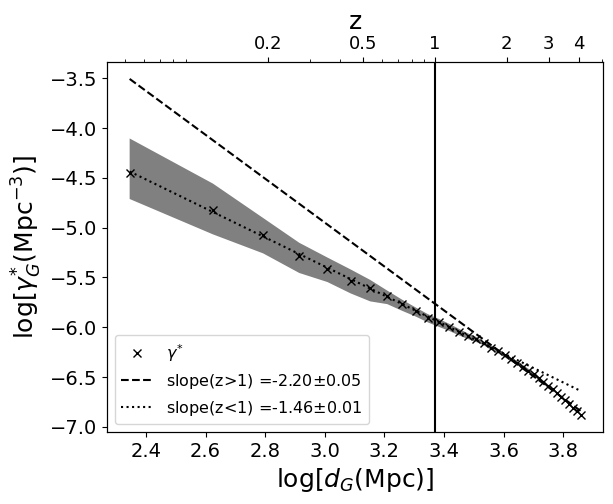

In [8]:
# Applying function 2
listagamadl1, listagamadl1_sup, listagamadl1_inf, listadl1, listaz1 = gama_dist(dbin=200, dist=dl, dist_sup=dl_sup, dist_inf=dl_inf, dist_type='dL')
listagamadz1, listagamadz1_sup, listagamadz1_inf, listadz1, listazz1 = gama_dist(dbin=200, dist=dz, dist_sup=dz_sup, dist_inf=dz_inf, dist_type='dZ')
listagamadg2, listagamadg2_sup, listagamadg2_inf, listadg2, listazg2 = gama_dist(dbin=200, dist=dg, dist_sup=dg_sup, dist_inf=dg_inf, dist_type='dG')

# Applying function 5
slope_g_dl, err_slope_g_dl, interp_g_dl, err_interp_g_dl, slope_l_dl, err_slope_l_dl, interp_l_dl, err_interp_l_dl = slopes('dL',listadl1,listagamadl1,listagamadl1_sup)
slope_g_dz, err_slope_g_dz, interp_g_dz, err_interp_g_dz, slope_l_dz, err_slope_l_dz, interp_l_dz, err_interp_l_dz = slopes('dZ',listadz1,listagamadz1,listagamadz1_sup)
slope_g_dg, err_slope_g_dg, interp_g_dg, err_interp_g_dg, slope_l_dg, err_slope_l_dg, interp_l_dg, err_interp_l_dg = slopes('dG',listadg2,listagamadg2,listagamadg2_sup)

# Applying function 6 to create the graphs
gama_plot(listadl1,listagamadl1,listaz1,'L',listagamadl1_sup,listagamadl1_inf,slope_l_dl,err_slope_l_dl,interp_l_dl,slope_g_dl,err_slope_g_dl,interp_g_dl)
gama_plot(listadz1,listagamadz1,listazz1,'Z',listagamadz1_sup,listagamadz1_inf,slope_l_dz,err_slope_l_dz,interp_l_dz,slope_g_dz,err_slope_g_dz,interp_g_dz)
gama_plot(listadg2,listagamadg2,listazg2,'G',listagamadg2_sup,listagamadg2_inf,slope_l_dg,err_slope_l_dg,interp_l_dg,slope_g_dg,err_slope_g_dg,interp_g_dg)